In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math 
import sys


In [16]:
# /home/gilad/dev_ws/camera_dev/images/march_31_10_Color.png
# /home/gilad/dev_ws/camera_dev/images/march_31_3_Color.png

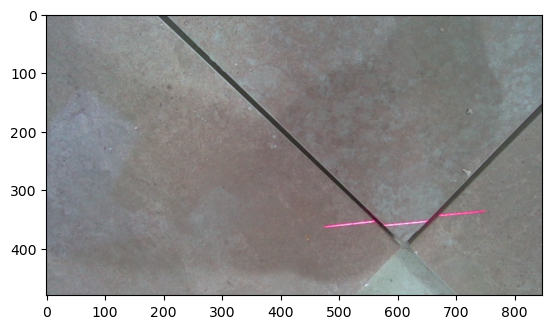

In [17]:
input_image = cv2.imread('/home/gilad/dev_ws/camera_dev/images/march_31_3_Color.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
plt.imshow(input_image)
plt.show()

In [18]:
def euc_dist(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
def resize_mask_to_arr(mask,width,height):
    return cv2.resize(mask,(width*height,1))
def resize_arr_to_mask(arr,width,height):
    return cv2.resize(arr,(width,height))
def point_in_mask(point,width):
    i = point // width
    j = point % width
    return i,j


def find_components(mask):
    visited = np.zeros(mask.shape,dtype=bool)
    components = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == 1 and not visited[i][j]:
                # print('found new component origin at:',i,j,'value:',mask[i][j])
                component = []
                component = DFS(mask,i,j,visited,component)
                components.append(component)
    return components

# def DFS(G, i,j, visited,component):
#     visited[i][j] = True
#     component.append((i,j))
#     # print(v)
#     moves = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(-1,-1),(1,-1),(-1,1)]
#     for move in moves:
#         i_new = i + move[0]
#         j_new = j + move[1]
#         if i_new >= 0 and i_new < G.shape[0] and j_new >= 0 and j_new < G.shape[1] and not visited[i_new][j_new]:
#             DFS(G,i_new,j_new,visited,component)
#     return component

def DFS(G, i, j, visited, component):
    stack = [(i, j)]
    while stack:
        i, j = stack.pop()
        if not visited[i][j]:
            visited[i][j] = True
            component.append((i, j))
            moves = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
            for move in moves:
                i_new = i + move[0]
                j_new = j + move[1]
                if 0 <= i_new < G.shape[0] and 0 <= j_new < G.shape[1] and not visited[i_new][j_new] and G[i_new][j_new] == 1:
                    stack.append([i_new, j_new])
    return component

def make_mask(component,shape):
    mask = np.zeros(shape=(shape[0],shape[1]))
    for point in component:
        mask[point[0]][point[1]] = 1
    return mask



(480, 848)
15


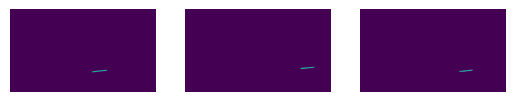

[406757    283]


In [19]:
mask = input_image[:,:,0] > 180

mask = mask.astype(np.uint8)
print(mask.shape)
# mask_arr = mask.flatten()
neighbors = find_components(mask)
neighbors.sort(key=lambda x: len(x),reverse=True)
for neighbor in neighbors:
    if len(neighbor) < 70:
        neighbors.remove(neighbor)
    for point in neighbor:
        i,j = point
        if(i >= mask.shape[0] or j >= mask.shape[1]):
            neighbor.remove(point)
        if(len(neighbor) < 70):
            mask[i][j] = 0
            
# for point in neighbors[0]:
#     i,j = point
#     print(i,j)
print(len(neighbors))
sub_mask_list = []
for i in range(3):
    mask_i = make_mask(neighbors[i],mask.shape)
    mask_i = mask_i.astype(np.uint8)
    sub_mask_list.append(mask_i)
    plt.subplot(1,3,i+1)
    plt.imshow(sub_mask_list[i])
    plt.axis('off')
    

plt.show()
unique, counts = np.unique(sub_mask_list[2], return_counts=True)
print(counts)
if(counts[1] < 70):
    sub_mask_list.pop(2)
# plt.imshow(mask)
# plt.show()

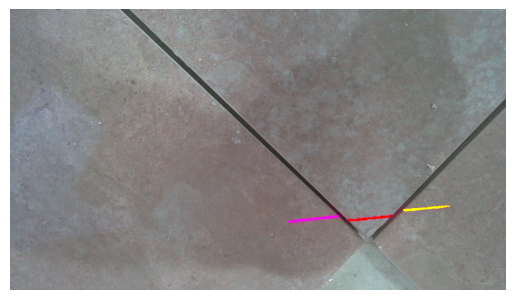

In [20]:
out_mask = cv2.bitwise_and(input_image, input_image, mask=sub_mask_list[0])
for i in range(1,len(sub_mask_list)):

    out_mask = cv2.bitwise_or(out_mask, cv2.bitwise_and(input_image, input_image, mask=sub_mask_list[i]))

out_image = input_image.copy()
for i in range(len(sub_mask_list)):
    out_image[sub_mask_list[i] == 1] = [255 if i%1 ==0 else 0,255 if i%2 ==1 else 0,255 if i%3 ==0 else 0]


plt.imshow(out_image)
plt.axis('off')
plt.show()

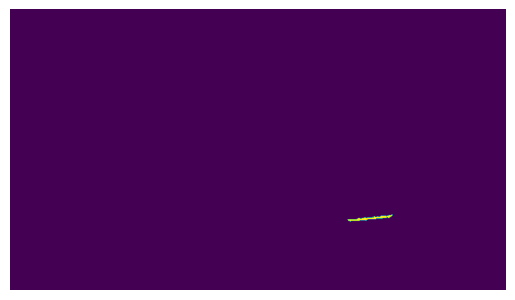

(480, 848)


In [21]:
if(len(sub_mask_list) >2):
    plt.imshow(sub_mask_list[2])
    plt.axis('off')
    plt.show()
    print(sub_mask_list[2].shape)


In [22]:
def find_component_with_feature(mask,mask_stats,debug = False):
    most_left = [0,mask.shape[1]]
    most_right = [0,0]
    most_top = [mask.shape[0],0]
    most_bottom = [0,0]
    
    # print(temp_val)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == 1:
                if debug:
                    print(i,j)
                if i < most_top[0]:
                    most_top = [i,j]
                if i > most_bottom[0]:
                    most_bottom = [i,j]
                if j < most_left[1]:
                    most_left = [i,j]
                if j > most_right[1]:
                    most_right = [i,j]

    # print(most_left,most_right,most_top,most_bottom)   
    mask_stats.append(most_left)
    mask_stats.append(most_right)
    mask_stats.append(most_top)        
    mask_stats.append(most_bottom)
    

                


left points:  [[363, 476], [342, 672], [359, 577]]
right points:  [[353, 562], [336, 751], [351, 653]]
up points:  [[352, 558], [335, 745], [351, 652]]
down points:  [[364, 476], [345, 675], [362, 581]]
[{'left': [359, 577], 'right': [351, 653], 'up': [351, 652], 'down': [362, 581]}, {'left': [363, 476], 'right': [353, 562], 'up': [352, 558], 'down': [364, 476]}]


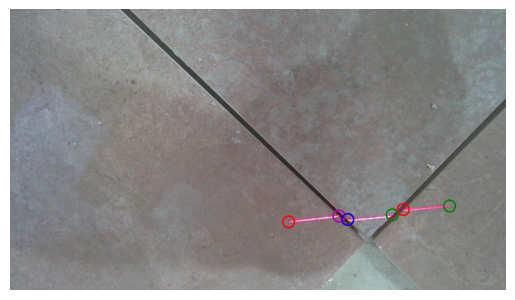

In [23]:



mask_0_stats = []
mask_1_stats = []
feats = []
find_component_with_feature(sub_mask_list[0],mask_0_stats),
find_component_with_feature(sub_mask_list[1],mask_1_stats),
if(len(sub_mask_list) > 2):
    mask_2_stats = []
    find_component_with_feature(sub_mask_list[2],mask_2_stats)
    left_points = [mask_0_stats[0],mask_1_stats[0],mask_2_stats[0]]
    right_points = [mask_0_stats[1],mask_1_stats[1],mask_2_stats[1]]
    up_points = [mask_0_stats[2],mask_1_stats[2],mask_2_stats[2]]
    down_points = [mask_0_stats[3],mask_1_stats[3],mask_2_stats[3]]
    feats = [
        {'left': mask_0_stats[0],'right': mask_0_stats[1],'up': mask_0_stats[2],'down': mask_0_stats[3]},
        {'left': mask_1_stats[0],'right': mask_1_stats[1],'up': mask_1_stats[2],'down': mask_1_stats[3]},
        {'left': mask_2_stats[0],'right': mask_2_stats[1],'up': mask_2_stats[2],'down': mask_2_stats[3]},
    ]
else:
    left_points = [mask_0_stats[0],mask_1_stats[0]]
    right_points = [mask_0_stats[1],mask_1_stats[1]]
    up_points = [mask_0_stats[2],mask_1_stats[2]]
    down_points = [mask_0_stats[3],mask_1_stats[3]]
    feats = [
        {'left': mask_0_stats[0],'right': mask_0_stats[1],'up': mask_0_stats[2],'down': mask_0_stats[3]},
        {'left': mask_1_stats[0],'right': mask_1_stats[1],'up': mask_1_stats[2],'down': mask_1_stats[3]},
    ]


print("left points: ", left_points)
print("right points: ", right_points)
print("up points: ", up_points)
print("down points: ", down_points)

feats.sort(key=lambda x: x['left'][1])
intrest_point_edge_far = feats[0]['right']
feats.sort(key=lambda x: x['right'][1],reverse=True)
if(len(feats) > 2):
    feats.remove(feats[0])
intrest_point_edge_close = feats[0]['left']
print(feats)


out_image_2 = input_image.copy()
for point in left_points:
    # print(point)
    i = point[0]
    j = point[1]
    out_image_2[i][j] = [0,0,255]
    circle = plt.Circle((j,i), 5, color='r', fill=False)
    plt.gca().add_patch(circle)
for point in right_points:
    i = point[0]
    j = point[1]
    out_image_2[i][j] = [0,255,0]
    circle = plt.Circle((j,i), 10, color='g', fill=False)
    plt.gca().add_patch(circle)
circle = plt.Circle((intrest_point_edge_far[1],intrest_point_edge_far[0]), 5, color='m', fill=False)
plt.gca().add_patch(circle)
circle = plt.Circle((intrest_point_edge_close[1],intrest_point_edge_close[0]), 5, color='b', fill=False)
plt.gca().add_patch(circle)

plt.imshow(out_image_2)
plt.axis('off')
plt.show()

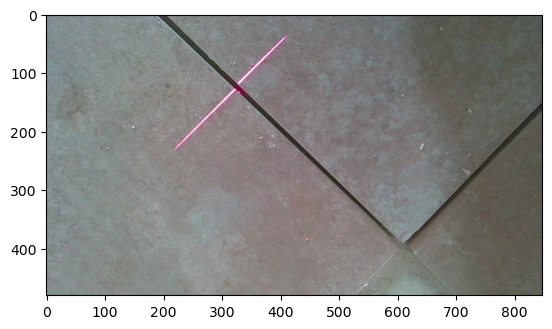

In [24]:
input_image_2 = cv2.imread('/home/gilad/dev_ws/camera_dev/images/march_31_10_Color.png')
input_image_2 = cv2.cvtColor(input_image_2, cv2.COLOR_BGR2RGB)
plt.imshow(input_image_2)
plt.show()

(480, 848)
15


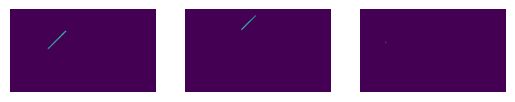

[407028     12]


In [25]:
mask = input_image_2[:,:,0] > 180

mask = mask.astype(np.uint8)
print(mask.shape)
# mask_arr = mask.flatten()
neighbors = find_components(mask)
neighbors.sort(key=lambda x: len(x),reverse=True)
for neighbor in neighbors:
    if len(neighbor) < 70:
        neighbors.remove(neighbor)
    for point in neighbor:
        i,j = point
        if(i >= mask.shape[0] or j >= mask.shape[1]):
            neighbor.remove(point)
        if(len(neighbor) < 70):
            mask[i][j] = 0
            
# for point in neighbors[0]:
#     i,j = point
#     print(i,j)
print(len(neighbors))
sub_mask_list = []
for i in range(3):
    mask_i = make_mask(neighbors[i],mask.shape)
    mask_i = mask_i.astype(np.uint8)
    sub_mask_list.append(mask_i)
    plt.subplot(1,3,i+1)
    plt.imshow(sub_mask_list[i])
    plt.axis('off')
    

plt.show()
unique, counts = np.unique(sub_mask_list[2], return_counts=True)
print(counts)
if(counts[1] < 70):
    sub_mask_list.pop(2)

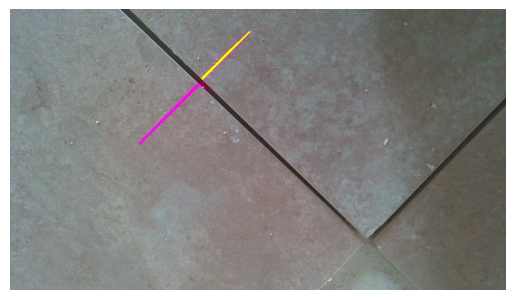

In [26]:
out_mask = cv2.bitwise_and(input_image_2, input_image_2, mask=sub_mask_list[0])
for i in range(1,len(sub_mask_list)):

    out_mask = cv2.bitwise_or(out_mask, cv2.bitwise_and(input_image, input_image, mask=sub_mask_list[i]))

out_image = input_image_2.copy()
for i in range(len(sub_mask_list)):
    out_image[sub_mask_list[i] == 1] = [255 if i%1 ==0 else 0,255 if i%2 ==1 else 0,255 if i%3 ==0 else 0]


plt.imshow(out_image)
plt.axis('off')
plt.show()

left points:  [[229, 220], [117, 326]]
right points:  [[131, 326], [38, 410]]
up points:  [[126, 319], [38, 408]]
down points:  [[231, 220], [120, 328]]
[{'left': [117, 326], 'right': [38, 410], 'up': [38, 408], 'down': [120, 328]}, {'left': [229, 220], 'right': [131, 326], 'up': [126, 319], 'down': [231, 220]}]


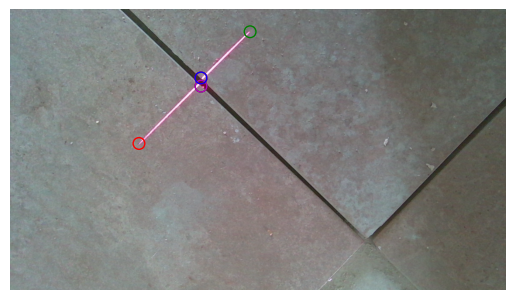

In [27]:
mask_0_stats = []
mask_1_stats = []
feats = []
find_component_with_feature(sub_mask_list[0],mask_0_stats),
find_component_with_feature(sub_mask_list[1],mask_1_stats),
if(len(sub_mask_list) > 2):
    mask_2_stats = []
    find_component_with_feature(sub_mask_list[2],mask_2_stats)
    left_points = [mask_0_stats[0],mask_1_stats[0],mask_2_stats[0]]
    right_points = [mask_0_stats[1],mask_1_stats[1],mask_2_stats[1]]
    up_points = [mask_0_stats[2],mask_1_stats[2],mask_2_stats[2]]
    down_points = [mask_0_stats[3],mask_1_stats[3],mask_2_stats[3]]
    feats = [
        {'left': mask_0_stats[0],'right': mask_0_stats[1],'up': mask_0_stats[2],'down': mask_0_stats[3]},
        {'left': mask_1_stats[0],'right': mask_1_stats[1],'up': mask_1_stats[2],'down': mask_1_stats[3]},
        {'left': mask_2_stats[0],'right': mask_2_stats[1],'up': mask_2_stats[2],'down': mask_2_stats[3]},
    ]
else:
    left_points = [mask_0_stats[0],mask_1_stats[0]]
    right_points = [mask_0_stats[1],mask_1_stats[1]]
    up_points = [mask_0_stats[2],mask_1_stats[2]]
    down_points = [mask_0_stats[3],mask_1_stats[3]]
    feats = [
        {'left': mask_0_stats[0],'right': mask_0_stats[1],'up': mask_0_stats[2],'down': mask_0_stats[3]},
        {'left': mask_1_stats[0],'right': mask_1_stats[1],'up': mask_1_stats[2],'down': mask_1_stats[3]},
    ]


print("left points: ", left_points)
print("right points: ", right_points)
print("up points: ", up_points)
print("down points: ", down_points)

feats.sort(key=lambda x: x['left'][1])
intrest_point_edge_far_2 = feats[0]['right']
feats.sort(key=lambda x: x['right'][1],reverse=True)
if(len(feats) > 2):
    feats.remove(feats[0])
intrest_point_edge_close_2 = feats[0]['left']
print(feats)


out_image_2 = input_image_2.copy()
for point in left_points:
    # print(point)
    i = point[0]
    j = point[1]
    out_image_2[i][j] = [0,0,255]
    circle = plt.Circle((j,i), 5, color='r', fill=False)
    plt.gca().add_patch(circle)
for point in right_points:
    i = point[0]
    j = point[1]
    out_image_2[i][j] = [0,255,0]
    circle = plt.Circle((j,i), 5, color='g', fill=False)
    plt.gca().add_patch(circle)
circle = plt.Circle((intrest_point_edge_far_2[1],intrest_point_edge_far_2[0]), 5, color='m', fill=False)
plt.gca().add_patch(circle)
circle = plt.Circle((intrest_point_edge_close_2[1],intrest_point_edge_close_2[0]), 5, color='b', fill=False)
plt.gca().add_patch(circle)

plt.imshow(out_image_2)
plt.axis('off')
plt.show()

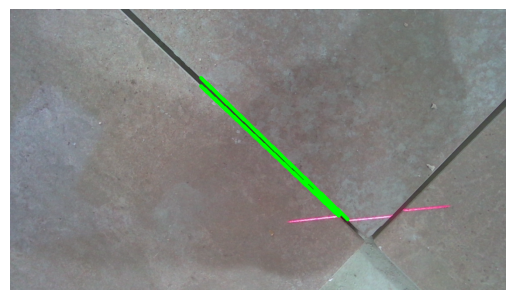

In [28]:
out_ = input_image.copy()
line1 = cv2.line(out_, (intrest_point_edge_far[1],intrest_point_edge_far[0]), (intrest_point_edge_far_2[1],intrest_point_edge_far_2[0]), (0,255,0), 5)
line2 = cv2.line(out_, (intrest_point_edge_close[1],intrest_point_edge_close[0]), (intrest_point_edge_close_2[1],intrest_point_edge_close_2[0]), (0,255,0), 5)
plt.imshow(out_)
plt.axis('off')
plt.show()
